In [5]:
# import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt

In [6]:
#upload csv
df_customers=pd.read_csv('olist_customers_dataset.csv')#https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/FUi5uSd6BfG_ig')
df_orders=pd.read_csv('olist_orders_dataset.csv')#https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/t9Li4JOfgxuUrg')
df_items=pd.read_csv('olist_order_items_dataset.csv')#https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/Gbt-yAcQrOe3Pw')

In [7]:
# change to datetime
df_orders['order_approved_at']=pd.to_datetime(df_orders.order_approved_at)
df_orders['order_delivered_customer_date']=pd.to_datetime(df_orders.order_delivered_customer_date)
df_orders['order_estimated_delivery_date']=pd.to_datetime(df_orders.order_estimated_delivery_date)
df_orders['order_purchase_timestamp']=pd.to_datetime(df_orders.order_purchase_timestamp)
df_orders['order_delivered_carrier_date']=pd.to_datetime(df_orders.order_delivered_carrier_date)
df_items['shipping_limit_date']=pd.to_datetime(df_items.shipping_limit_date)

In [8]:
#1. merge orders & customers
df_ord_cust=df_orders.merge(df_customers,how='left')
# customs with one purchase
custs_with_1_purchase=df_ord_cust.query('order_approved_at==order_approved_at') \
    .groupby('customer_unique_id',as_index=False) \
    .agg({'order_id':'count'}) \
    .sort_values('order_id',ascending=False) \
    .query('order_id==1') \
    .shape[0]
custs_with_1_purchase

93049

In [9]:
#2.timedelta from delivery to carrier and delivery to customer, mean, std
df_ord_cust['td']=df_ord_cust.order_delivered_customer_date-df_ord_cust.order_delivered_carrier_date
print('mean =',df_ord_cust.td.dropna().mean(),' \n std =',df_ord_cust.td.dropna().std())

mean = 9 days 07:55:59.254148743  
 std = 8 days 18:14:34.522067763


order_status
approved        0.083333
canceled       26.041667
processing     12.541667
shipped        46.083333
unavailable    25.375000
dtype: float64

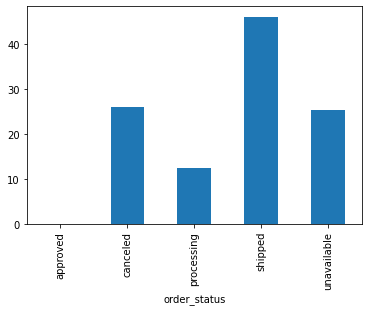

In [65]:
#2. mean of undelivered orders
#new column YYYY-MM
df_orders['order_purchase_yr_mnth']=df_orders.order_purchase_timestamp.dt.to_period("M")
#count of undelivered orders by status
c=df_orders.query('order_status!=["delivered","created","invoiced"] and order_id!="54282e97f61c23b78330c15b154c867d"') \
    .groupby(['order_purchase_yr_mnth','order_status'],as_index=False) \
    .agg({'order_id':'count'}) \
    .sort_values('order_purchase_yr_mnth')
#mean of undelivered orders & barplot
undelivered_purchs_mean=c.pivot(index='order_purchase_yr_mnth', columns='order_status', values='order_id').fillna(0).mean()
undelivered_purchs_mean.plot.bar()
undelivered_purchs_mean

,product_id,weekday_nmbrs,weekday_names
0,00066f42aeeb9f3007548bb9d3f33c38,3,wednesday
1,00088930e925c41fd95ebfe695fd2655,2,tuesday
2,0009406fd7479715e4bef61dd91f2462,5,friday
3,000b8f95fcb9e0096488278317764d19,3,wednesday
4,000d9be29b5207b54e86aa1b1ac54872,2,tuesday
...,...,...,...
32943,fff6177642830a9a94a0f2cba5e476d1,1,monday
32944,fff81cc3158d2725c0655ab9ba0f712c,1,monday
32945,fff9553ac224cec9d15d49f5a263411f,6,saturday
32946,fffdb2d0ec8d6a61f0a0a0db3f25b441,2,tuesday


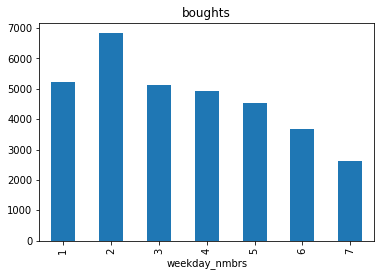

In [6]:
#3.
#func for replace №weekday on names of weekday
#def weekday(weekday):
#    wd={1:'monday', 2:'tuesday', 3:'wednesday', 4:'thursday', 5:'friday', 6:'saturday', 7:'sunday'}
#    return wd[weekday]
#3. day of the week on which the goods are most often bought
#merge items & orders
df_items_orders=df_items.merge(df_orders, how="left")
#remove rows with Na in 'order_approved_at' column
df_items_orders=df_items_orders.query('order_approved_at==order_approved_at')
#create column weekday 
df_items_orders['weekday']=df_items_orders.order_approved_at.dt.weekday+1
#group by product_id, weekday
prdckt_sls_wkdy=df_items_orders.groupby(['product_id','weekday'],as_index=False)\
    .agg({'seller_id':'count'})\
    .sort_values('product_id')
#create dict with key-product & value-weekday with max purchases
sales_by_weekday={}
sales_by_weekday['00066f42aeeb9f3007548bb9d3f33c38']=3
for i in range(1,prdckt_sls_wkdy.shape[0]):
    if prdckt_sls_wkdy.product_id[i]!=prdckt_sls_wkdy.product_id[i-1]:
        sales_by_weekday[prdckt_sls_wkdy.product_id[i]]=prdckt_sls_wkdy.weekday[i]
    if prdckt_sls_wkdy.product_id[i]==prdckt_sls_wkdy.product_id[i-1]:        
        if prdckt_sls_wkdy.seller_id[i]>prdckt_sls_wkdy.seller_id[i-1]:
            sales_by_weekday[prdckt_sls_wkdy.product_id[i]]=prdckt_sls_wkdy.weekday[i]
#create dataframe from dict
wkds_max_sales=pd.DataFrame(list(sales_by_weekday.items()), columns=['product_id', 'weekday_nmbrs'])
#create names of weekday from №weekday
wd={1:'monday', 2:'tuesday', 3:'wednesday', 4:'thursday', 5:'friday', 6:'saturday', 7:'sunday'}
wkds_max_sales['weekday_names']=wkds_max_sales.weekday_nmbrs.apply(lambda x: wd[x])   
#day of the week on which the goods are most often bought
wkds_max_sales.groupby('weekday_nmbrs') \
    .agg({'product_id':'count'}) \
    .sort_values('weekday_nmbrs') \
    .plot.bar(title='boughts',legend=False)
wkds_max_sales

In [4]:
4.
#merge orders & customers
df_ord_cust=df_orders.merge(df_customers,how='left')
#new column YYYY-MM
df_ord_cust['order_approved_yr_mnth']=df_ord_cust.order_approved_at.dt.to_period("M")
#remove rows with Na in 'order_approved_at' column & count of orders by unique customers by month
df_custs_by_month=df_ord_cust.query('order_approved_at==order_approved_at') \
    .groupby(['customer_unique_id','order_approved_yr_mnth'],as_index=False) \
    .agg({'customer_state':'count'}) \
    .sort_values('order_approved_yr_mnth')
#create column weeks_of_month
df_custs_by_month['week_of_month']=df_custs_by_month.order_approved_yr_mnth.dt.days_in_month/7
#create column boughts_by_week
df_custs_by_month['boughts_by_week']=df_custs_by_month.customer_state/df_custs_by_month.week_of_month
#boughts by week
boughts_by_week=df_custs_by_month.pivot(index='customer_unique_id',columns='order_approved_yr_mnth',values='boughts_by_week') \
    .fillna(0)
boughts_by_week

order_approved_yr_mnth,2016-09,2016-10,2016-12,2017-01,2017-02,2017-03,2017-04,2017-05,2017-06,2017-07,...,2017-12,2018-01,2018-02,2018-03,2018-04,2018-05,2018-06,2018-07,2018-08,2018-09
customer_unique_id,,,,,,,,,,,,,,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,0.0,0.0,0.0,0.0,0.00,0.000000,0.0,0.000000,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.225806,0.0,0.0,0.0,0.0
0000b849f77a49e4a4ce2b2a4ca5be3f,0.0,0.0,0.0,0.0,0.00,0.000000,0.0,0.000000,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.225806,0.0,0.0,0.0,0.0
0000f46a3911fa3c0805444483337064,0.0,0.0,0.0,0.0,0.00,0.225806,0.0,0.000000,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
0000f6ccb0745a6a4b88665a16c9f078,0.0,0.0,0.0,0.0,0.00,0.000000,0.0,0.000000,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
0004aac84e0df4da2b147fca70cf8255,0.0,0.0,0.0,0.0,0.00,0.000000,0.0,0.000000,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fffcf5a5ff07b0908bd4e2dbc735a684,0.0,0.0,0.0,0.0,0.00,0.000000,0.0,0.000000,0.233333,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
fffea47cd6d3cc0a88bd621562a9d061,0.0,0.0,0.0,0.0,0.00,0.000000,0.0,0.000000,0.000000,0.0,...,0.225806,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
ffff371b4d645b6ecea244b27531430a,0.0,0.0,0.0,0.0,0.25,0.000000,0.0,0.000000,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0


,order_approved_yr_mnth,orders_quantity,td
first_order_month,,,
2017-12,2018-03,21,3
2018-03,2018-06,21,3
2018-01,2018-04,20,3
2017-09,2017-12,18,3
2018-02,2018-05,18,3
2018-04,2018-07,16,3
2018-05,2018-08,15,3
2017-05,2017-08,14,3
2017-06,2017-09,13,3


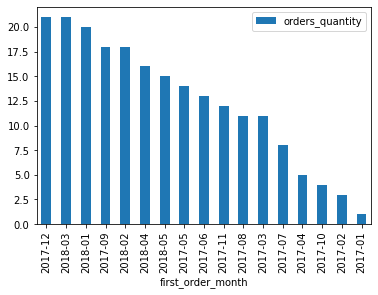

In [8]:
#5 
#merge orders & customers
df_ord_cust=df_orders.merge(df_customers,how='left')
#remove rows with Na in 'order_approved_at' column
df_ord_cust=df_ord_cust.query('order_approved_at==order_approved_at')
#remove orders with status invoiced, canceled
#df_ord_cust=df_ord_cust.query("order_status!=['invoiced', 'canceled']")
#new column YYYY-MM
df_ord_cust['order_approved_yr_mnth']=df_ord_cust.order_approved_at.dt.to_period("M")
#df with date of first order by unique customers
first_order_date=df_ord_cust.groupby('customer_unique_id',as_index=False).agg({'order_approved_at':'min'})
first_order_date=first_order_date.rename(columns={'order_approved_at':'first_order_month'})
first_order_date['first_order_month']=first_order_date.first_order_month.dt.to_period("M")
#merge orders with new df-first_order_date
df_ord_cust_kog=df_ord_cust.merge(first_order_date)
#create cohorts by first order date & count month orders by cohorts 
df_kog=df_ord_cust_kog.groupby(['first_order_month','order_approved_yr_mnth'],as_index=False) \
    .agg({'customer_unique_id':'count'})
#timedelta from month order & first order month
df_kog['td']=df_kog.order_approved_yr_mnth.view(dtype='int64')-df_kog.first_order_month.view(dtype='int64')
#filtration by 3rd month, sorting by orders quantity
df_kog_3m=df_kog.query('td=="3"') \
    .sort_values('customer_unique_id', ascending=False)\
    .set_index('first_order_month') \
    .rename(columns={'customer_unique_id':'orders_quantity'})
df_kog_3m.plot.bar(y='orders_quantity')
df_kog_3m

In [16]:
#6
#funcs for create category for rfm (for recency - less is better)
def Class(val,cat,dct):
    if val <= dct[cat][0.2]:
        return 1
    elif val <= dct[cat][0.4]:
        return 2
    elif val <= dct[cat][0.6]:
        return 3
    elif val <= dct[cat][0.8]:
        return 4
    else:
        return 5
def Class_req(val,cat,dct):
    if val <= dct[cat][0.2]:
        return 5
    elif val <= dct[cat][0.4]:
        return 4
    elif val <= dct[cat][0.6]:
        return 3
    elif val <= dct[cat][0.8]:
        return 2
    else:
        return 1
#in df items group by order for create of order price 
df_order_monet=df_items.groupby('order_id',as_index=False).agg({'price':'sum'}).sort_values('price',ascending=False)
#merge orders & customers
df_ord_cust=df_orders.merge(df_customers,how='left')
#remove rows with Na in 'order_approved_at' column
df_ord_cust=df_ord_cust.query('order_approved_at==order_approved_at')
#merge orders_customers & items with order price
df_ord_cast_monet=df_ord_cust.merge(df_order_monet, how='left')
#remove rows with Na in 'price' column
df_ord_cast_monet=df_ord_cast_monet.query('price==price')
#add column current date(last date in df)
df_ord_cast_monet['current_date']=df_ord_cast_monet.order_approved_at.max()
#add column with timedelta from current date and order date
df_ord_cast_monet['td_from_current_date']=(df_ord_cast_monet.current_date-df_ord_cast_monet.order_approved_at).dt.days
#group by unique customers and count frequency, monetary, recency and create df rfm 
rfm=df_ord_cast_monet.groupby('customer_unique_id',as_index=False) \
    .agg({'td_from_current_date':'max','order_id':'count', 'price':'sum'}) \
    .rename(columns={'order_id':'frequency', 'price':'monetary', 'td_from_current_date':'recency'})
#counting quantiles
quants=rfm.quantile(q=[0.2,0.4,0.6,0.8], interpolation='linear').to_dict()
#add columns for category of recency, frequency, monetary
rfm['recency_cat']=rfm.recency.apply(Class_req, args=('recency',quants))
rfm['frequency_cat']=rfm.frequency.apply(Class, args=('frequency',quants))
rfm['monetary_cat']=rfm.monetary.apply(Class, args=('monetary',quants))
#add column for rfm category
rfm['category']=(rfm.recency_cat*100+rfm.frequency_cat*10+rfm.monetary_cat).astype('str')
rfm.sort_values('category',ascending=False)

,customer_unique_id,recency,frequency,monetary,recency_cat,frequency_cat,monetary_cat,category
30904,52b8fc428690f8974a3d3ff3a162f7b7,75,2,339.80,5,5,5,555
37168,636443768344855307bfe5f2f2f6ba2e,96,2,253.97,5,5,5,555
14281,2642f11f7c5588a63213b5e67e8ad0a7,33,2,255.19,5,5,5,555
68964,b8beb7a6bfb7ed884386a8da46be8f8e,47,2,282.99,5,5,5,555
9499,194f1bab01e4e36f4255603e9a427b89,65,2,219.90,5,5,5,555
...,...,...,...,...,...,...,...,...
12124,205a1c797b2c6e626d560900a3ebde6b,571,1,24.90,1,1,1,111
40981,6da1f239b54ae1312f44837503ff6d1a,478,1,15.75,1,1,1,111
86107,e6c2d4c0d18521155e20e567476bcbac,570,1,20.00,1,1,1,111
63268,a99021699fda65c2b84a3fb596a4c32b,531,1,29.90,1,1,1,111


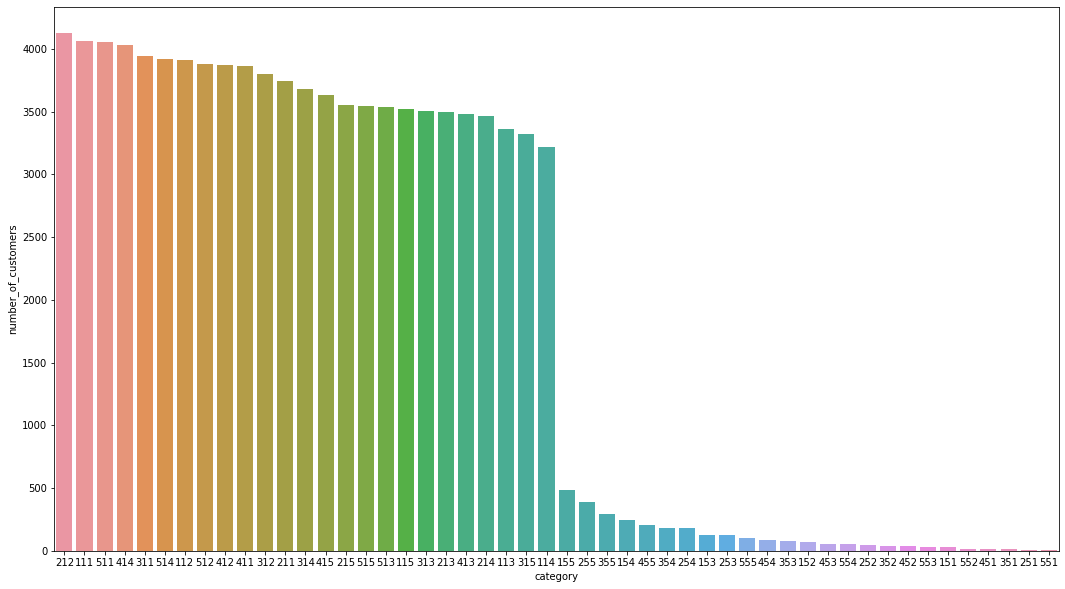

In [15]:
plt.figure(figsize=(18,10))
rfm_amount=rfm.groupby('category',as_index=False) \
    .agg({'customer_unique_id':'count'}) \
    .rename(columns={'customer_unique_id':'number_of_customers'}) \
    .sort_values('number_of_customers',ascending=False)
sns.barplot(data=rfm_amount, x='category', y='number_of_customers')
plt.show()